# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/Shareddrives/cis522_project/cleaned_data")

# Preparing Training and Testing Datasets (saved to train.csv and test.csv) 

In [4]:
ladieswear = pd.read_csv('filtered_articles.csv')
customers = pd.read_csv('filtered_customer.csv', index_col=0)
transactions = pd.read_csv("filtered_transactions.csv", index_col=0)
print(len(ladieswear))
print(len(customers))
print(len(transactions))

1988
4980
146499


Here we directly use the one-hot encoding of data entries from the cleaned datasets, with no extra embedding. 

One-hot Encoding for Customers

In [5]:
customers_categorical = pd.get_dummies(customers[['club_member_status','fashion_news_frequency']])
customers_with_id = pd.concat([customers[['customer_id', 'age']],customers_categorical], axis=1)
customers_features = customers_with_id.drop(columns = 'customer_id') # feature only
customers_with_id.head(2)

,customer_id,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly
378,00123f33890b09df6220e166ff7017307d46d6bedb7d41...,30.0,1,0,0,1,0
491,0016b98191cdd059be5662dbf1d2b634cbfb7132b1d62f...,54.0,1,0,0,1,0


One-hot Encoding for Articles

In [6]:
articles = pd.get_dummies(ladieswear[['product_type_name','product_group_name','colour_group_name','department_name','index_name','section_name']])
articles_with_id = pd.concat([ladieswear['article_id'],articles], axis=1)
articles_with_id.head(2)

,article_id,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,...,section_name_Womens Everyday Collection,section_name_Womens Jackets,section_name_Womens Lingerie,"section_name_Womens Nightwear, Socks & Tigh",section_name_Womens Premium,section_name_Womens Shoes,section_name_Womens Small accessories,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend
0,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108775044,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Cross product

In [7]:
X = articles_with_id.merge(customers_with_id, how='cross')

In [8]:
X.head(2)

,article_id,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,...,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend,customer_id,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0,00123f33890b09df6220e166ff7017307d46d6bedb7d41...,30.0,1,0,0,1,0
1,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0,0016b98191cdd059be5662dbf1d2b634cbfb7132b1d62f...,54.0,1,0,0,1,0


Get all existing transactions from the transactions table. 

In [9]:
all_transactions = transactions[['customer_id','article_id']].drop_duplicates()
all_transactions_tuples = all_transactions.itertuples(index=False)
all_transactions_set = set([tuple(x) for x in all_transactions_tuples])

All customer-article pairs from the merged dataset. 

In [10]:
all_pairs = X[['customer_id','article_id']]
all_pairs_tuples = [tuple(x) for x in all_pairs.itertuples(index=False)]

In [11]:
# ex. 
all_pairs_tuples[0]

('00123f33890b09df6220e166ff7017307d46d6bedb7d41fc0e6eacc91d94b9eb', 108775015)

We can now attatch the label for each user-item instance. If the user has bought the item, i.e. the user-item pair can be found in the existing transactions, label=1; otherwise, label=0.

In [12]:
X['label'] = [1 if all_pairs_tuples[i] in all_transactions_set else 0 for i in range(len(all_pairs_tuples))]

We take all instances of label 1 and sample the same number of instances with label 0 from, to shrink the dimension of data while balancing the samples. 

In [14]:
sampled_X_1 = X[X['label']==1]
sampled_X_0 = X[X['label']==0].sample(len(X[X['label']==1]))
sampled_X = pd.concat([sampled_X_1, sampled_X_0], axis=0)
sampled_X

,article_id,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,...,section_name_Womens Tailoring,section_name_Womens Trend,customer_id,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly,label
10,108775015,0,0,0,0,0,0,0,0,0,...,0,0,00c301ac78a4335914d5a0968ffed6f32adf848d953244...,26.0,1,0,0,0,1,1
25,108775015,0,0,0,0,0,0,0,0,0,...,0,0,01713a77d14e22acc5a2bbe40ce969e0734dc6eb1b0a30...,25.0,1,0,0,1,0,1
34,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0210aa3885256277849be00802f90848858e220839095b...,31.0,1,0,0,1,0,1
206,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0b92816ac86c5a1da9049324f3707c5ad944a6112e6e25...,53.0,1,0,0,0,1,1
238,108775015,0,0,0,0,0,0,0,0,0,...,0,0,0d5ca5efeeab48330be12f745b4312c312c34109a0c5b6...,29.0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2592511,649437002,0,0,0,0,0,0,0,0,0,...,0,0,94e9d91649dae960ee10db1e34af49cdac2f4b74a5a753...,44.0,1,0,0,1,0,0
7064601,775321003,0,0,0,0,0,0,0,0,0,...,0,0,972ea1ac35f0b0d9ed666e362f617ae79dc8394196b51d...,64.0,1,0,0,0,1,0
8583079,820168001,0,0,0,0,1,0,0,0,0,...,0,0,81afdc9f0c4f77f06b6bd0f162026bb8e8f2678a9d7406...,25.0,1,0,0,0,1,0
4623317,713199006,0,0,0,1,0,0,0,0,0,...,0,0,6121534002e33a7cfd01846c1e7bfe8bca30502b49577b...,28.0,1,0,0,1,0,0


In [15]:
# shuffle the sampled X
X = sampled_X.sample(frac=1, random_state=42).reset_index(drop=True)

Since we are spliting by the joined tuples of customers and articles, customers from test data might have appeared in train data.
We need to remove the records with potential duplicate customer form test data, which is the last customer from train data.

In [16]:
train_size = int(len(X)*0.8)

train_data = X.iloc[:train_size]
test_data = X.iloc[train_size:]

potential_duplicate = train_data.customer_id.iloc[-1]
test_data = test_data[test_data.customer_id != potential_duplicate]

print(len(train_data))
print(len(test_data))

181075
45259


In [17]:
# Remove customer and article id 
train_with_id = train_data.copy()
test_with_id = test_data.copy()
train_data = train_data.drop(columns=['customer_id','article_id'])
test_data = test_data.drop(columns=['customer_id','article_id'])

In [18]:
# train_data.to_csv('train.csv')
# test_data.to_csv('test.csv')

# Spliting features and target

In [24]:
train_data

,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Boots,product_type_name_Bra,product_type_name_Cardigan,...,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend,age,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_None,fashion_news_frequency_Regularly,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,28.0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,47.0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,32.0,1,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,47.0,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,24.0,1,0,0,1,0,1
181071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,52.0,1,0,0,0,1,1
181072,0,0,0,0,0,1,0,0,0,0,...,0,0,0,44.0,1,0,0,1,0,0
181073,0,0,0,1,0,0,0,0,0,0,...,1,0,0,25.0,1,0,0,1,0,1


We can then divide the train/test data into features and target and convert them to nparrays(by .values) then to tensors.

In [25]:
X_train, y_train = torch.tensor(train_data.iloc[:,:-1].values), torch.tensor(train_data.iloc[:,-1].values)
X_test, y_test = torch.tensor(test_data.iloc[:,:-1].values), torch.tensor(test_data.iloc[:,-1].values)

In [26]:
print(X_train.shape)
print(y_train.shape)

torch.Size([181075, 173])
torch.Size([181075])


In [27]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=0)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)


# Multilayer Perceptron

Define the MLP model. We used part of the code from W3D2 lecture notes. 

In [28]:
class Net(nn.Module):
    def __init__(self, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()

        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          self.layers += [nn.Linear(num_inputs, next_num_inputs), nn.BatchNorm1d(next_num_inputs), nn.ReLU()]
          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)

        # xavier init
        for m in self.layers:
          if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.xavier_uniform_(self.out.weight)

    def forward(self, x):
        # flattening
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
          x = layer(x)
        x = self.out(x)
        x = F.sigmoid(x)
        return x


Define the training loop. Here we use the Binary Cross Entropy loss and Adam for optimizer. 

In [44]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
def train(net, lr, num_epochs=1):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
  # optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01, last_epoch= -1, verbose=False)
  net.to(dev)
  net.train()
  training_losses = []
  for epoch in range(num_epochs): 
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
        
          inputs = inputs.to(dev).float()
          labels = labels.to(dev).float()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels.unsqueeze(1))
          loss.backward()
          optimizer.step()
          if not (i % 1000):
            print('Loss of epoch %d, iter %d: %.2f' % (epoch, i, loss.item()))
            training_losses.append(loss.item())
      scheduler.step()
      print("Current lr: ", scheduler.get_last_lr())

  plt.plot(np.arange(len(training_losses))*100, np.array(training_losses))
  plt.xlabel('Batch')
  plt.ylabel('Training Loss')
  plt.show()

Define the test function.

In [30]:
def test(net, dataloader): 
  net.to(dev)
  net.eval()
  correct = 0
  total = 0
  for data in dataloader:
      inputs, labels = data
      inputs = inputs.to(dev).float()
      labels = labels.to(dev).long()

      outputs = net(inputs).squeeze()
      # print(outputs)
      predicted = (outputs>0.5).int()
      # print(predicted)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return total, acc


# Train the network. 

Loss of epoch 0, iter 0: 0.84
Loss of epoch 0, iter 1000: 0.77
Loss of epoch 0, iter 2000: 0.70
Current lr:  [1e-05]
Loss of epoch 1, iter 0: 0.66
Loss of epoch 1, iter 1000: 0.71
Loss of epoch 1, iter 2000: 0.70
Current lr:  [1e-05]
Loss of epoch 2, iter 0: 0.70
Loss of epoch 2, iter 1000: 0.67
Loss of epoch 2, iter 2000: 0.70
Current lr:  [1.0000000000000001e-07]
Loss of epoch 3, iter 0: 0.68
Loss of epoch 3, iter 1000: 0.69
Loss of epoch 3, iter 2000: 0.66
Current lr:  [1.0000000000000001e-07]
Loss of epoch 4, iter 0: 0.67
Loss of epoch 4, iter 1000: 0.67
Loss of epoch 4, iter 2000: 0.67
Current lr:  [1.0000000000000001e-07]


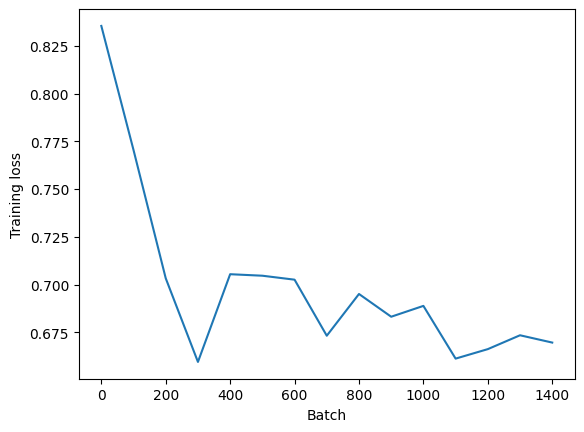

In [45]:
# training block
net = Net(num_inputs = 173, hidden_units = [64,128,256,128,64], num_outputs = 1)
train(net, lr = 1e-5, num_epochs=5)

# Evaluations using Test Accuracy

We can first evaluate the result using the test data and accuracy.

In [46]:
# testing on train loader and test loader 
train_total, train_acc = test(net, train_loader)
test_total, test_acc = test(net, test_loader)

print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))
print('Accuracy on the %d testing samples: %0.2f %%' % (test_total, test_acc))

Accuracy on the 181056 training samples: 54.72 %
Accuracy on the 45259 testing samples: 53.90 %


# Recommendations

Making actual recommendations:

Given a specific customer c, we first create a tensor of (article, c) pairs, matching the customer with all possible articles in the complete set of 1988 articles by concatenating the c's features with each article's features. This tensor is fed to MLP to get a score for each article. We pick the 50 items with the highest scores (highest probability to be bought) as the final recommendation for this customer. 

In [47]:
def recommend(net, customer_id):
  # output will be a 50*2 dataframe with columns (article_id, score)
  net.to(dev)
  net.eval()
  res_df = pd.DataFrame({'article_id':[], 'score':[]})
  # for each article, get a the score of y(c,a) from nn for ALL articles
  c_features = customers_with_id[customers_with_id['customer_id']==customer_id].drop(columns = ['customer_id'])
  c_features_tensor = torch.tensor(c_features.to_numpy())
  for i in range(len(articles_with_id)):
    article_id = articles_with_id['article_id'].iloc[i]
    a_features = articles_with_id.drop(columns = ['article_id']).iloc[i:i+1]
    a_features_tensor = torch.tensor(a_features.to_numpy())
    all_features = torch.concat((a_features_tensor, c_features_tensor), axis=1).to(dev).float()
    with torch.no_grad():
      pred_score = net(all_features)
    pred_score = pred_score.to('cpu').numpy().item()
    res_df.loc[len(res_df)] = (article_id, pred_score)
  # sort res_df and get the top 50 recommended articles
  res_df = res_df.sort_values('score', ascending=False).head(50)
  return res_df

## Visualize the result with a random customer

To unify visualizations across all methods, we choose the same customer to make recommendations for: 

In [48]:
cid = '09218960c278039863ca72e08255c245ade5466e3b90bf718a142087b5d27646'
rec = recommend(net, cid)

In [49]:
rec

,article_id,score
743,695584001.0,0.727263
148,516859008.0,0.727263
36,224606019.0,0.727263
607,673396002.0,0.727263
608,673396015.0,0.727263
22,179950017.0,0.727263
21,179950001.0,0.727263
357,589748001.0,0.727263
206,554792001.0,0.727263
147,516859002.0,0.727263


We first visualize the clothes this customer actually bought and then the clothes we recommends to this customers.

In [50]:
rec_articles = rec.article_id
real_articles = transactions[transactions['customer_id']==cid]['article_id'].drop_duplicates()

In [51]:
# Articles actually bought
images = []
import cv2
for id in real_articles:
  item = int(id)
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  images.append(cv2.imread(name1)[:,:,::-1])

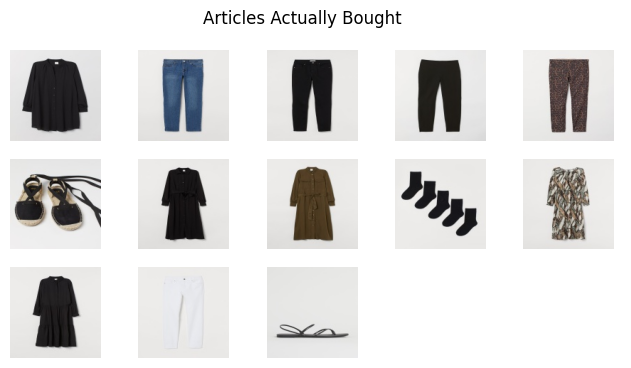

In [57]:
fig, axs = plt.subplots(3,5,figsize=(8,4))
fig.suptitle('Articles Actually Bought')
for i in range(3):
  for j in range(5):
    axs[i,j].grid(False)
    axs[i,j].axis("off")
    try:
      img = images[i*5+j%5]
      axs[i,j].imshow(img)
    except:
      continue
fig.savefig('Articles Actually Bought', dpi = 1000)

We then visualize the 50 recommended articles.

In [53]:
# Articles recommended 
rec_images = []
for id in rec_articles:
  item = int(id)
  name1 = '/content/drive/Shareddrives/cis522_project/data/images_128_128/'+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
  rec_images.append(cv2.imread(name1)[:,:,::-1])

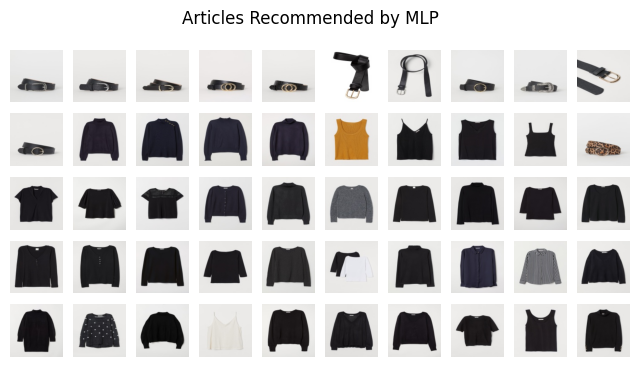

In [54]:
fig, axs = plt.subplots(5,10,figsize=(8,4))
fig.suptitle('Articles Recommended by MLP')
for i in range(5):
  for j in range(10):
    axs[i,j].grid(False)
    axs[i,j].axis("off")
    try:
      img = rec_images[i*10+j%10]
      axs[i,j].imshow(img)
    except:
      continue
fig.savefig('Articles Recommended by MLP.png', dpi = 1000)

# Evalutation of the Recommendation Results 

For each customer in the test set, we make 50 recommendations. We can check the intersection between the recommended articles set and the set of articles actually bought by the customer. If there is an overlap, the customer is considered a hit. We will then calculate #hits/#customers.

In [55]:
# To shorten evaluation time, we evaluate the method with only 100 customers
test_customers = test_with_id.customer_id.unique()[:100]
print('There are %d unique customers in the test set.' % len(test_customers))

There are 100 unique customers in the test set.


In [56]:
hit = 0
num_customers = 0
for cid in test_customers:
  rec = set(recommend(net, cid)['article_id'])
  real_articles = set(all_transactions[all_transactions['customer_id']==cid]['article_id'])
  if len(rec.intersection(real_articles))!=0:
    hit+=1
  num_customers += 1
print("Hit Rate: ", hit/num_customers)

Hit Rate:  0.56
